In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split

#Preprocessing

## Reading in for CSV files

In [0]:
specs = pd.read_csv("/content/drive/My Drive/introml/data-science-bowl-2019/specs.csv")
test = pd.read_csv("/content/drive/My Drive/introml/data-science-bowl-2019/test.csv")
train = pd.read_csv("/content/drive/My Drive/introml/data-science-bowl-2019/train.csv")
train_labels = pd.read_csv("/content/drive/My Drive/introml/data-science-bowl-2019/train_labels.csv")

## removal of unwanted rows and columns

In [0]:
#dropping 
# 1. title --> welcome to lost lagoon is a start screen (world == None) (can drop)
# 2. some take the assessment but are not in train_labels 
# 3. some didn’t take assessment
# 4. Event data (its already out into individual columns) 

#drop world == NONE
train = train[train['world'] != 'NONE']

#drop rows that are not found inside train_label data --> never take assessment
assessment_data_id = list(train_labels['installation_id'].unique())
train = train[train['installation_id'].isin(assessment_data_id)]

#drop event_data 
train.drop(columns='event_data')

print(train.shape)

(7727620, 11)


In [0]:
train.head()

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
1539,27253bdc,4b57c9a59474a1b9,2019-08-06T04:57:45.301Z,"{""event_code"": 2000, ""event_count"": 1}",0006a69f,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK
1540,77261ab5,2b9d5af79bcdb79f,2019-08-06T04:58:14.538Z,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",0006a69f,1,2000,0,Sandcastle Builder (Activity),Activity,MAGMAPEAK
1541,b2dba42b,2b9d5af79bcdb79f,2019-08-06T04:58:14.615Z,"{""description"":""Let's build a sandcastle! Firs...",0006a69f,2,3010,29,Sandcastle Builder (Activity),Activity,MAGMAPEAK
1542,1325467d,2b9d5af79bcdb79f,2019-08-06T04:58:16.680Z,"{""coordinates"":{""x"":273,""y"":650,""stage_width"":...",0006a69f,3,4070,2137,Sandcastle Builder (Activity),Activity,MAGMAPEAK
1543,1325467d,2b9d5af79bcdb79f,2019-08-06T04:58:18.474Z,"{""coordinates"":{""x"":863,""y"":237,""stage_width"":...",0006a69f,4,4070,3937,Sandcastle Builder (Activity),Activity,MAGMAPEAK


In [0]:
train_labels.head(10)

,game_session,installation_id,title,num_correct,num_incorrect,accuracy,accuracy_group
0,6bdf9623adc94d89,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3
1,77b8ee947eb84b4e,0006a69f,Bird Measurer (Assessment),0,11,0.0,0
2,901acc108f55a5a1,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3
3,9501794defd84e4d,0006a69f,Mushroom Sorter (Assessment),1,1,0.5,2
4,a9ef3ecb3d1acc6a,0006a69f,Bird Measurer (Assessment),1,0,1.0,3
5,197a373a77101924,0006c192,Cauldron Filler (Assessment),1,0,1.0,3
6,957406a905d59afd,0006c192,Bird Measurer (Assessment),1,1,0.5,2
7,b2297d292892745a,0006c192,Mushroom Sorter (Assessment),0,4,0.0,0
8,ae691ec5ad5652cf,00129856,Bird Measurer (Assessment),1,0,1.0,3
9,7b536271e99518f0,001d0ed0,Bird Measurer (Assessment),0,5,0.0,0


## finding out the count of each event

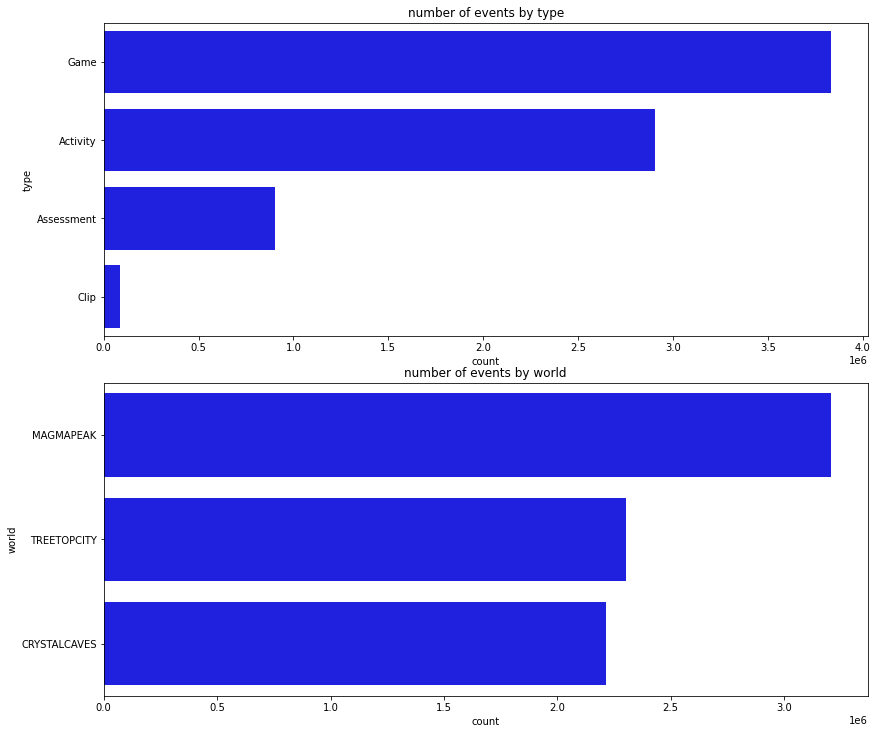

In [0]:
fig = plt.figure(figsize=(12,10))
ax1 = fig.add_subplot(211)
ax1 = sns.countplot(y="type", data=train, color="blue", order = train.type.value_counts().index)
plt.title("number of events by type")

ax2 = fig.add_subplot(212)
ax2 = sns.countplot(y="world", data=train, color="blue", order = train.world.value_counts().index)
plt.title("number of events by world")

plt.tight_layout(pad=0)
plt.show()

In [0]:
train.corr()

,event_count,event_code,game_time
event_count,1.000000,0.036415,0.193182
event_code,0.036415,1.000000,0.008339
game_time,0.193182,0.008339,1.000000


In [0]:
combination = train_labels[['game_session', 'accuracy_group']]
combination

,game_session,accuracy_group
0,6bdf9623adc94d89,3
1,77b8ee947eb84b4e,0
2,901acc108f55a5a1,3
3,9501794defd84e4d,2
4,a9ef3ecb3d1acc6a,3
...,...,...
17685,c996482b11d149dd,3
17686,b05a02b52d5c1f4c,3
17687,5448d652309a6324,1
17688,a6885ab824fbc32c,0


In [0]:
train = train.merge(combination, on=['game_session'])

In [0]:
train

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world,accuracy_group
0,3bfd1a65,901acc108f55a5a1,2019-08-06T05:22:01.344Z,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",0006a69f,1,2000,0,Mushroom Sorter (Assessment),Assessment,TREETOPCITY,3
1,db02c830,901acc108f55a5a1,2019-08-06T05:22:01.400Z,"{""event_count"":2,""game_time"":37,""event_code"":2...",0006a69f,2,2025,37,Mushroom Sorter (Assessment),Assessment,TREETOPCITY,3
2,a1e4395d,901acc108f55a5a1,2019-08-06T05:22:01.403Z,"{""description"":""Pull three mushrooms out of th...",0006a69f,3,3010,37,Mushroom Sorter (Assessment),Assessment,TREETOPCITY,3
3,a52b92d5,901acc108f55a5a1,2019-08-06T05:22:05.242Z,"{""description"":""Pull three mushrooms out of th...",0006a69f,4,3110,3901,Mushroom Sorter (Assessment),Assessment,TREETOPCITY,3
4,a1e4395d,901acc108f55a5a1,2019-08-06T05:22:05.244Z,"{""description"":""To pick a mushroom, pull it ou...",0006a69f,5,3010,3901,Mushroom Sorter (Assessment),Assessment,TREETOPCITY,3
...,...,...,...,...,...,...,...,...,...,...,...,...
865442,28520915,5448d652309a6324,2019-09-22T02:07:27.562Z,"{""misses"":1,""prompt"":""holds least"",""mode"":""sel...",ffeb0b1b,58,2030,67094,Cauldron Filler (Assessment),Assessment,MAGMAPEAK,1
865443,91561152,5448d652309a6324,2019-09-22T02:07:27.562Z,"{""bucket"":1,""buckets_placed"":[3,1,2],""target_b...",ffeb0b1b,57,4025,67094,Cauldron Filler (Assessment),Assessment,MAGMAPEAK,1
865444,d3268efa,5448d652309a6324,2019-09-22T02:07:27.566Z,"{""description"":""Awesome."",""identifier"":""Dot_Aw...",ffeb0b1b,59,3021,67094,Cauldron Filler (Assessment),Assessment,MAGMAPEAK,1
865445,b5053438,5448d652309a6324,2019-09-22T02:07:28.311Z,"{""description"":""Awesome."",""identifier"":""Dot_Aw...",ffeb0b1b,60,3121,67847,Cauldron Filler (Assessment),Assessment,MAGMAPEAK,1


# Feature Engineering

## Function for feature engineering

In [0]:
def count_group_combine(df):
    
    #group 1 gets the total time spend in the session of a user of that particular game and type and world
    #it also gets the total number of events that happen in that sessions (player clicks, wrongs, hints, corrects)
    group1 = df.drop(columns=['event_id', 'event_code']).groupby(
            ['game_session', 'installation_id', 'title', 'type', 'world', 'accuracy_group']).max().reset_index()

    base = group1[['installation_id', 'accuracy_group']]

    # group 2 is the count of the number of times each event_code happens for each installation ID
    group2 = pd.get_dummies(df[['installation_id', 'event_code']], 
                            columns=['event_code']).groupby(['installation_id']).sum()
    
    #group 3 is making use of group 1 where they get the number of times the player played each title, type and in what world
    group3 = pd.get_dummies(group1.drop(columns=['game_session', 'event_count', 'game_time']),
                            columns=['title', 'type', 'world']).groupby(['installation_id']).sum()
    
    
    #group 4 is to get the basic sum mean and standard deviation of gametime
    group4 = group1[['installation_id', 'game_time']].groupby(['installation_id']).agg([np.sum, np.mean, np.std])



    
    return group2.join(group3).join(group4).join(base)


In [0]:
train.drop(columns=['event_id', 'event_code']).groupby(
            ['game_session', 'installation_id', 'title', 'type', 'world', 'accuracy_group']).max().reset_index()

In [0]:
new_train_df = count_group_combine(train).reset_index()

In [0]:
new_train_df

,installation_id,event_code_2000,event_code_2010,event_code_2020,event_code_2025,event_code_2030,event_code_2035,event_code_3010,event_code_3020,event_code_3021,event_code_3110,event_code_3120,event_code_3121,event_code_4020,event_code_4025,event_code_4030,event_code_4035,event_code_4040,event_code_4070,event_code_4080,event_code_4090,event_code_4100,event_code_4110,accuracy_group,title_Bird Measurer (Assessment),title_Cart Balancer (Assessment),title_Cauldron Filler (Assessment),title_Chest Sorter (Assessment),title_Mushroom Sorter (Assessment),type_Assessment,world_CRYSTALCAVES,world_MAGMAPEAK,world_TREETOPCITY,"(game_time, sum)","(game_time, mean)","(game_time, std)","(accuracy_group, sum)","(accuracy_group, mean)","(accuracy_group, std)"
0,0006a69f,5.0,4.0,6.0,3.0,5.0,3.0,16.0,12.0,13.0,16.0,12.0,13.0,18.0,34.0,46.0,0.0,3.0,18.0,0.0,0.0,5.0,12.0,11,2,0,0,0,3,5,0,0,5,227640,45528.000000,26871.152245,11,2.200000,1.303840
1,0006c192,3.0,0.0,4.0,1.0,2.0,1.0,12.0,6.0,6.0,12.0,6.0,5.0,32.0,10.0,56.0,4.0,12.0,159.0,0.0,1.0,6.0,2.0,5,1,0,1,0,1,3,0,1,2,322671,107557.000000,101867.356582,5,1.666667,1.527525
2,00129856,1.0,1.0,2.0,0.0,2.0,0.0,5.0,0.0,1.0,5.0,0.0,1.0,3.0,3.0,7.0,0.0,0.0,7.0,0.0,0.0,1.0,1.0,3,1,0,0,0,0,1,0,0,1,39701,39701.000000,NaN,3,3.000000,NaN
3,001d0ed0,5.0,3.0,5.0,2.0,3.0,2.0,15.0,7.0,9.0,15.0,7.0,9.0,10.0,19.0,27.0,2.0,1.0,43.0,0.0,0.0,5.0,5.0,8,1,1,0,1,2,5,2,0,3,194670,38934.000000,13579.559032,8,1.600000,1.516575
4,00225f67,1.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0,0.0,1.0,1.0,0.0,0.0,12.0,12.0,0.0,0.0,4.0,0.0,0.0,0.0,2.0,0,1,0,0,0,0,1,0,0,1,26517,26517.000000,NaN,0,0.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3609,ff9305d7,4.0,0.0,6.0,0.0,2.0,0.0,14.0,22.0,2.0,14.0,21.0,2.0,11.0,60.0,101.0,5.0,24.0,83.0,0.0,0.0,7.0,17.0,2,2,0,0,2,0,4,2,0,2,316889,79222.250000,58932.357537,2,0.500000,0.577350
3610,ff9715db,9.0,7.0,10.0,3.0,8.0,3.0,30.0,10.0,21.0,30.0,9.0,20.0,46.0,18.0,66.0,2.0,14.0,34.0,0.0,0.0,18.0,0.0,21,0,3,1,2,3,9,5,1,3,1906759,211862.111111,517186.440608,21,2.333333,1.118034
3611,ffc90c32,6.0,5.0,8.0,2.0,7.0,2.0,19.0,2.0,14.0,18.0,2.0,14.0,28.0,14.0,44.0,3.0,2.0,43.0,0.0,0.0,8.0,1.0,16,1,1,1,1,2,6,2,1,3,219523,36587.166667,14693.704957,16,2.666667,0.816497
3612,ffd2871d,1.0,1.0,2.0,0.0,2.0,0.0,3.0,0.0,3.0,3.0,0.0,3.0,4.0,1.0,6.0,0.0,2.0,8.0,0.0,0.0,1.0,0.0,3,0,0,1,0,0,1,0,1,0,54533,54533.000000,NaN,3,3.000000,NaN


In [0]:
new_df.shape

(3614, 96)

In [0]:
# import feather
# path1 = '/content/drive/My Drive/introml/fe/fe1/train.feather'
# feather.write_dataframe(new_df, path1)

# path2 = '/content/drive/My Drive/introml/fe/fe1/test.feather'
# feather.write_dataframe(new_test_df, path2)

## Joining train data and train label

In [0]:
labels = train_labels[['installation_id', 'accuracy_group']].set_index('installation_id')
train_df = new_train_df.set_index('installation_id')
train_joined = train_df.join(labels)

In [0]:
train_joined

,event_code_2000,event_code_2010,event_code_2020,event_code_2025,event_code_2030,event_code_2035,event_code_2040,event_code_2050,event_code_2060,event_code_2070,event_code_2075,event_code_2080,event_code_2081,event_code_2083,event_code_3010,event_code_3020,event_code_3021,event_code_3110,event_code_3120,event_code_3121,event_code_4010,event_code_4020,event_code_4021,event_code_4022,event_code_4025,event_code_4030,event_code_4031,event_code_4035,event_code_4040,event_code_4045,event_code_4050,event_code_4070,event_code_4080,event_code_4090,event_code_4095,event_code_4100,event_code_4110,event_code_4220,event_code_4230,event_code_4235,...,title_Crystal Caves - Level 1,title_Crystal Caves - Level 2,title_Crystal Caves - Level 3,title_Crystals Rule,title_Dino Dive,title_Dino Drink,title_Egg Dropper (Activity),title_Fireworks (Activity),title_Flower Waterer (Activity),title_Happy Camel,"title_Heavy, Heavier, Heaviest",title_Honey Cake,title_Leaf Leader,title_Lifting Heavy Things,title_Magma Peak - Level 1,title_Magma Peak - Level 2,title_Mushroom Sorter (Assessment),title_Ordering Spheres,title_Pan Balance,title_Pirate's Tale,title_Rulers,title_Sandcastle Builder (Activity),title_Scrub-A-Dub,title_Slop Problem,title_Treasure Map,title_Tree Top City - Level 1,title_Tree Top City - Level 2,title_Tree Top City - Level 3,title_Watering Hole (Activity),type_Activity,type_Assessment,type_Clip,type_Game,world_CRYSTALCAVES,world_MAGMAPEAK,world_TREETOPCITY,"(game_time, sum)","(game_time, mean)","(game_time, std)",accuracy_group
installation_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0006a69f,76.0,4.0,112.0,12.0,97.0,8.0,21.0,18.0,7.0,2.0,3.0,17.0,6.0,10.0,620.0,34.0,89.0,610.0,34.0,89.0,19.0,404.0,67.0,45.0,128.0,471.0,25.0,35.0,18.0,4.0,0.0,592.0,0.0,4.0,2.0,13.0,14.0,13.0,25.0,25.0,...,0.0,0.0,0.0,3.0,2.0,3.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,4.0,3.0,4.0,2.0,0.0,2.0,2.0,6.0,4.0,6.0,3.0,2.0,2.0,2.0,3.0,17.0,6.0,33.0,20.0,0.0,35.0,41.0,5575453,73361.223684,181119.737956,3
0006a69f,76.0,4.0,112.0,12.0,97.0,8.0,21.0,18.0,7.0,2.0,3.0,17.0,6.0,10.0,620.0,34.0,89.0,610.0,34.0,89.0,19.0,404.0,67.0,45.0,128.0,471.0,25.0,35.0,18.0,4.0,0.0,592.0,0.0,4.0,2.0,13.0,14.0,13.0,25.0,25.0,...,0.0,0.0,0.0,3.0,2.0,3.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,4.0,3.0,4.0,2.0,0.0,2.0,2.0,6.0,4.0,6.0,3.0,2.0,2.0,2.0,3.0,17.0,6.0,33.0,20.0,0.0,35.0,41.0,5575453,73361.223684,181119.737956,0
0006a69f,76.0,4.0,112.0,12.0,97.0,8.0,21.0,18.0,7.0,2.0,3.0,17.0,6.0,10.0,620.0,34.0,89.0,610.0,34.0,89.0,19.0,404.0,67.0,45.0,128.0,471.0,25.0,35.0,18.0,4.0,0.0,592.0,0.0,4.0,2.0,13.0,14.0,13.0,25.0,25.0,...,0.0,0.0,0.0,3.0,2.0,3.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,4.0,3.0,4.0,2.0,0.0,2.0,2.0,6.0,4.0,6.0,3.0,2.0,2.0,2.0,3.0,17.0,6.0,33.0,20.0,0.0,35.0,41.0,5575453,73361.223684,181119.737956,3
0006a69f,76.0,4.0,112.0,12.0,97.0,8.0,21.0,18.0,7.0,2.0,3.0,17.0,6.0,10.0,620.0,34.0,89.0,610.0,34.0,89.0,19.0,404.0,67.0,45.0,128.0,471.0,25.0,35.0,18.0,4.0,0.0,592.0,0.0,4.0,2.0,13.0,14.0,13.0,25.0,25.0,...,0.0,0.0,0.0,3.0,2.0,3.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,4.0,3.0,4.0,2.0,0.0,2.0,2.0,6.0,4.0,6.0,3.0,2.0,2.0,2.0,3.0,17.0,6.0,33.0,20.0,0.0,35.0,41.0,5575453,73361.223684,181119.737956,2
0006a69f,76.0,4.0,112.0,12.0,97.0,8.0,21.0,18.0,7.0,2.0,3.0,17.0,6.0,10.0,620.0,34.0,89.0,610.0,34.0,89.0,19.0,404.0,67.0,45.0,128.0,471.0,25.0,35.0,18.0,4.0,0.0,592.0,0.0,4.0,2.0,13.0,14.0,13.0,25.0,25.0,...,0.0,0.0,0.0,3.0,2.0,3.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,4.0,3.0,4.0,2.0,0.0,2.0,2.0,6.0,4.0,6.0,3.0,2.0,2.0,2.0,3.0,17.0,6.0,33.0,20.0,0.0,35.0,41.0,5575453,73361.223684,181119.737956,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ffc90c32,51.0,5.0,63.0,5.0,56.0,3.0,4.0,3.0,4.0,1.0,3.0,6.0

In [0]:
#should not have any that are NA because we already drop those that didnt take the assessment or 
# we have no records of their data before doing assessment
train_joined.isna().sum()
train_joined.isna().sum()

event_code_2000      0
event_code_2010      0
event_code_2020      0
event_code_2025      0
event_code_2030      0
                    ..
world_TREETOPCITY    0
(game_time, sum)     0
(game_time, mean)    0
(game_time, std)     7
accuracy_group       0
Length: 96, dtype: int64

In [0]:
X_all = train_joined.drop(columns='accuracy_group')
y_all = train_joined['accuracy_group']
print(y_all.shape)
X_all.shape

In [0]:
X_train, X_test,y_train, y_test = train_test_split(X_all, y_all, test_size=0.3, random_state=42, shuffle=True)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)